In [38]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [39]:

    

# Define a transformação para converter a imagem em tensor
transform = transforms.Compose([transforms.ToTensor()])


# Baixa e carrega o dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

no7 = (train_data.targets != 7)
only7 = (test_data.targets == 7)

train_data.data = train_data.data[no7]
train_data.targets = train_data.targets[no7]


test_data.data = test_data.data[only7]
test_data.targets = test_data.targets[only7]


In [40]:
batchsize = 256
loaderTrain = DataLoader(train_data, shuffle=True, batch_size=batchsize, drop_last=True)
loaderTest = DataLoader(test_data, batch_size=len(test_data))

In [41]:
torch.argmax(train_data[1][0], axis=1)

tensor([[ 0,  0,  0,  0,  0,  0, 19, 19, 14, 12, 11, 10,  9,  9,  7,  6,  9,  4,
          5,  6,  9, 14, 14,  0,  0,  0,  0,  0]])

In [42]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [43]:
%whos

Variable         Type          Data/Info
----------------------------------------
DataLoader       type          <class 'torch.utils.data.dataloader.DataLoader'>
F                module        <module 'torch.nn.functio<...>/torch/nn/functional.py'>
X                Tensor        tensor([[[[0., 0., 0.,  .<...>0.,  ..., 0., 0., 0.]]]])
batchsize        int           256
createMNISTNet   function      <function createMNISTNet at 0x7a93c761eb00>
datasets         module        <module 'torchvision.data<...>on/datasets/__init__.py'>
loaderTest       DataLoader    <torch.utils.data.dataloa<...>object at 0x7a93be9d30a0>
loaderTrain      DataLoader    <torch.utils.data.dataloa<...>object at 0x7a93be7f3910>
loss             Tensor        tensor(2.3448, grad_fn=<NllLossBackward0>)
lossfun          NLLLoss       NLLLoss()
net              ann           ann(\n  (bnIn): BatchNorm<...>features=9, bias=True)\n)
nn               module        <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
no7 

In [44]:
def createMNISTNet():
    class ann(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.bnIn = nn.BatchNorm1d(784)
            self.input = nn.Linear(784, 64)
            
            self.bn1 = nn.BatchNorm1d(64)
            self.fc1 = nn.Linear(64,32)
            
            self.bn2 = nn.BatchNorm1d(32)
            self.fc2 = nn.Linear(32,32)
            
            self.bn3 = nn.BatchNorm1d(32)
            self.output = nn.Linear(32,10)
        
        def forward(self, x):
            x = x.view(-1,784)
            
            x = F.relu(self.bnIn(x))
            x = self.input(x)
            
            x = F.relu(self.bn1(x))
            x = self.fc1(x)
            x = F.relu(self.bn2(x))
            x = self.fc2(x)
            x = F.relu(self.bn3(x))
            
            return torch.log_softmax(self.output(x), axis=1)
    
    net = ann()
    lossfun = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    
    return net, lossfun, optimizer

def trainModel(net, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    losses = []
    
    for epoch in range(20):
        batchAcc = []
        batchLoss = []
        net.train()
        
        for X,y in loaderTrain:
            y_pred = net(X)
            
            loss = lossfun(y_pred, y)
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = 100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item()
            batchAcc.append(acc)
    
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        net.eval()

        X, y = next(iter(loaderTest))
        y_pred = net(X)

        testAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
    return trainAcc, testAcc, losses
    
        
            

In [45]:
net, lossfun, optimizer = createMNISTNet()
X,y = next(iter(loaderTrain))

y_pred = net(X)

print(y_pred)
loss = lossfun(y_pred,y)
print("Loss", loss)

tensor([[-3.0653, -1.5923, -3.7724,  ..., -3.1135, -1.8954, -3.2765],
        [-2.1372, -1.5493, -2.4041,  ..., -2.3539, -2.6794, -3.2890],
        [-2.6596, -1.9809, -3.2154,  ..., -2.4465, -1.9662, -2.1093],
        ...,
        [-2.4246, -1.7457, -2.9982,  ..., -2.7767, -2.0968, -2.8404],
        [-2.3597, -2.0743, -2.2983,  ..., -2.5469, -2.1483, -2.2695],
        [-2.3695, -2.2000, -2.4197,  ..., -2.4630, -2.1695, -2.2485]],
       grad_fn=<LogSoftmaxBackward0>)
Loss tensor(2.4819, grad_fn=<NllLossBackward0>)


In [71]:
lista = torch.argmax(y_pred[:13], axis=1).detach().tolist()
lista


[9, 9, 9, 2, 2, 2, 3, 3, 9, 2, 2, 9, 9]

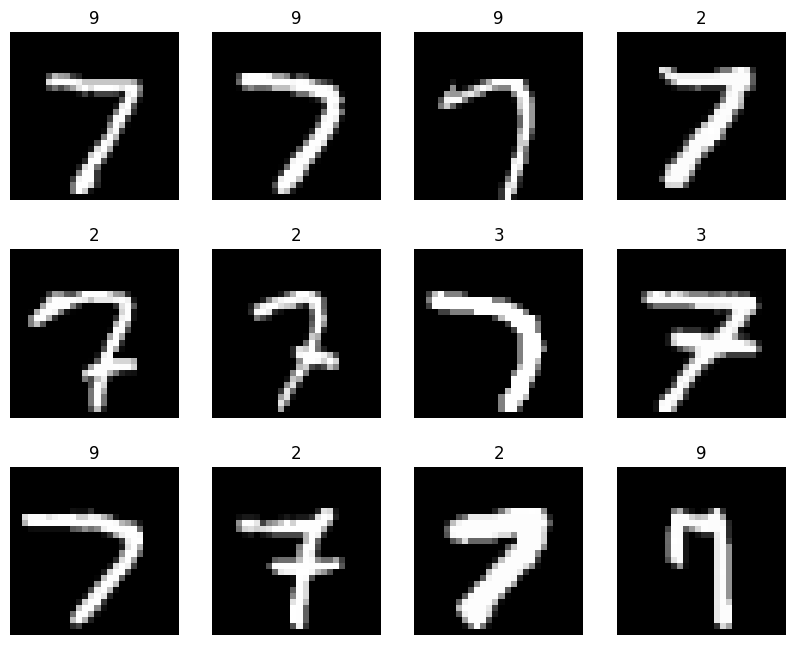

In [72]:
fig, axs = plt.subplots(3,4, figsize=(10,8))

axs = axs.flatten()

for i in range(min(12, len(X))):
    
    img = X[i].detach().cpu().numpy().reshape(28, 28)
    
    # 3. Plotamos no eixo específico
    axs[i].imshow(img, cmap='gray') # cmap='gray' deixa preto e branco
    
    # Estética: Remove os ticks dos eixos para ficar limpo
    axs[i].axis('off')
    
    axs[i].set_title(lista[i])

In [46]:
print(torch.exp(y_pred))

tensor([[0.0466, 0.2034, 0.0230,  ..., 0.0444, 0.1503, 0.0378],
        [0.1180, 0.2124, 0.0903,  ..., 0.0950, 0.0686, 0.0373],
        [0.0700, 0.1379, 0.0401,  ..., 0.0866, 0.1400, 0.1213],
        ...,
        [0.0885, 0.1745, 0.0499,  ..., 0.0622, 0.1228, 0.0584],
        [0.0945, 0.1256, 0.1004,  ..., 0.0783, 0.1167, 0.1034],
        [0.0935, 0.1108, 0.0890,  ..., 0.0852, 0.1142, 0.1056]],
       grad_fn=<ExpBackward0>)


In [47]:
train, test, loss = trainModel(net, lossfun, optimizer)

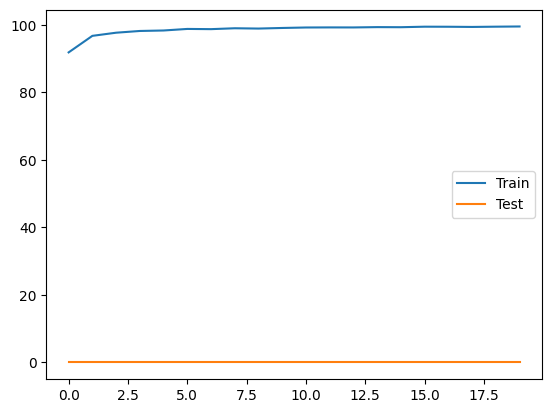

In [48]:
plt.plot(train)
plt.plot(test)
plt.legend("Train Test".split())


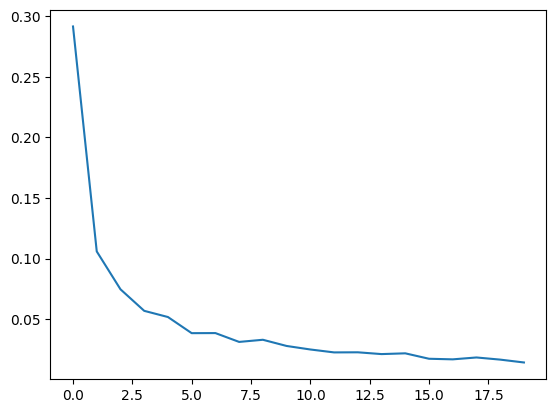

In [49]:
plt.plot(loss)

In [50]:
X, y = next(iter(loaderTest))
y_pred = net(X)

In [51]:
torch.exp(y_pred[0])

tensor([2.3286e-07, 1.1506e-05, 8.2780e-05, 2.6496e-03, 5.2877e-06, 9.9553e-06,
        7.8226e-09, 3.7080e-07, 1.8240e-04, 9.9706e-01],
       grad_fn=<ExpBackward0>)